In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import pickle
import math
import matplotlib.pyplot as plt

from types import SimpleNamespace
from pathlib import Path
from types import SimpleNamespace

from generative_models import *
from classification_models import *
from classification_trainer import *
from utils import *
from report_results import *

from torch.utils.data import DataLoader, Subset



In [2]:

def get_classification_config(exp_name):
    config_path = Path('results')
    config_file = config_path / exp_name / "classification_config.json"
    with open(config_file, 'r') as f:
        config = json.load(f)
    
    return SimpleNamespace(**config)


config = get_classification_config(exp_name)


## 加载数据集

In [3]:

phaseTransition = get_phaseTransition(config)
X, labels, ground_states = process_phase_transition_data(phaseTransition)

## 加载模型

In [4]:

trainer = ClassificationTrainer(config)
# trainer.model.load_generative(f'./results/{exp_name}/best_model.pth')
trainer.model.load_generative_and_classification(f'./results/{exp_name}/classification_best_model.pth')
trainer.load_data(X, labels)

x_list, predict_list = predict_with_train_dataset(trainer)

## 展示分类器预测

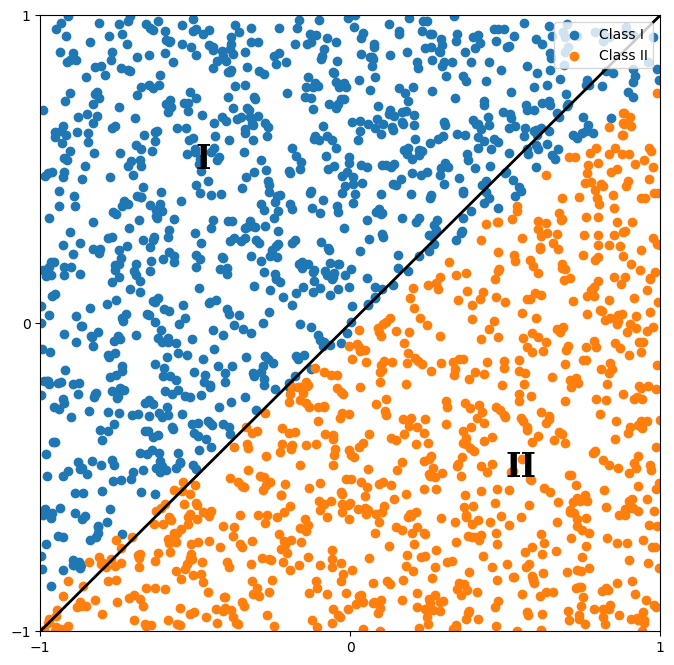

In [9]:

model_predict_for_validation(x_list, predict_list, config.dataset)

## 分析控制情况

In [6]:
#TFIM
# step = 0.6

# SPTS
step = 0.5


control_iter = 30

# 假设我们想要从每个类中抽取 n 个样本
n = 5
n_classes = 4
n_samples = n * n_classes


In [7]:

# 初始化一个空列表来存储选中的样本索引
selected_indices = []

# 对每个类别进行循环
for class_idx in range(n_classes):
    # 从这个类别中抽取 n 个样本
    class_indices = [i for i, (input, label) in enumerate(trainer.val_loader.dataset) if ((label == class_idx) and (input[0] != -1.1628639957433187))]
    selected_indices.extend(class_indices[:n])

# 创建一个新的 DataLoader，只包含选中的样本
control_loader = DataLoader(Subset(trainer.val_loader.dataset, selected_indices), batch_size=n_samples, shuffle=False)

# 获取样本 (这里只有一个 batch)
inputs, targets = next(iter(control_loader))



/var/folders/rh/54dmgc2x7c9g3x418js23j680000gn/T/ipykernel_44247/4074219517.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  transform_input = torch.tensor(transform_input_np, requires_grad=True)


[[-0.10093148447626364, 0.062264098873013964], [0.5455409572383547, -0.6913417407576125], [0.4506207147804349, -0.5800743567436654], [0.46727419829084754, -0.5944996503188514], [0.4659325354669801, -0.5888245004424059], [0.46854651110222345, -0.5878862106594365], [0.47014101280260007, -0.5860444664625885], [0.47182516333258584, -0.5845348213370777], [0.4733610079392596, -0.5830734051036731], [0.47481001968499204, -0.5817151719655006], [0.47616634850471173, -0.5804402724932186], [0.47743860100237023, -0.5792460899843834], [0.4786316395137441, -0.5781266733025231], [0.4797506895227757, -0.577077284021558], [0.48080045924417697, -0.5760933419380341], [0.4817853708485109, -0.575170626132938], [0.48270953963578017, -0.5743051986111529], [0.4835768068015729, -0.5734933930328576], [0.48439075765086426, -0.5727317915019242], [0.48515474082198967, -0.5720172063727277], [0.48587188527439895, -0.571346663012313], [0.4865451159819892, -0.5707173842046097], [0.48717716830582863, -0.5701267758465886

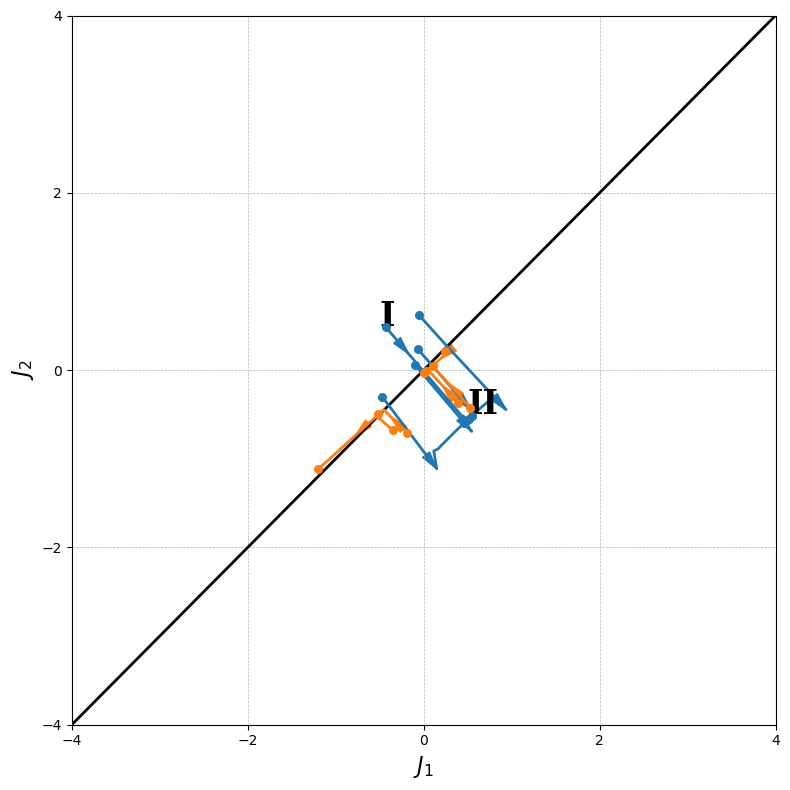

In [8]:
trainer.model.classification_params.requires_grad_(True)
trainer.model.params.requires_grad_(True)

trajectories = []
init_true_labels = []
for input, init_true_label in zip(inputs, targets):
    transform_input = sigmoid_transform(input)
    trajactory = [input.tolist()]
    for _ in range(control_iter):
        transform_input_np = transform_input.detach()
        transform_input = torch.tensor(transform_input_np, requires_grad=True)
        grad = get_direction_to_control_generation(trainer, transform_input, init_true_label, config.categories)
        # print(grad)
        transform_input = transform_input - step*grad
        if (transform_input[0] < -math.pi/ 2) or (transform_input[0] > math.pi/ 2):
            break
        if (transform_input[1] < -math.pi/ 2) or (transform_input[1] > math.pi/ 2):
            break
        inverse_input = inverse_sigmoid_transform(transform_input)
        trajactory.append(inverse_input.tolist())
        # print(transform_input)
    print(trajactory)
    trajectories.append(trajactory)
    init_true_labels.append(init_true_label)
    
plot_phase_diagram_with_trajactory(config.dataset, exp_name, trajectories, init_true_labels, show_plot=True)